# Agric ChatBot

In [1]:
!pip install evaluate

In [2]:
#Importing
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from transformers import BertTokenizer
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
from pathlib import Path
from transformers import Seq2SeqTrainingArguments
import re
import torch
import numpy as np
from transformers import (
    BertTokenizer,
    EncoderDecoderModel,
    Trainer,
    TrainingArguments,
    DataCollatorForSeq2Seq,
)
from datasets import Dataset
import evaluate

2025-06-21 11:52:28.532496: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750506748.995719     246 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750506749.117404     246 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import warnings
warnings.filterwarnings('ignore')


# Data

In [4]:

data = pd.read_csv("/kaggle/input/farmers-call-query-data-qa/questionsv4.csv")


In [5]:
data.describe()


,questions,answers
count,178939,178816
unique,90930,99353
top,query regarding pmkisan.,explain in details
freq,1065,3130


In [6]:
print(data[:2])


                                           questions  \
0  asking about the control measure for aphid inf...   
1  asking about the control measure of flower dro...   

                                             answers  
0  suggested him to spray rogor@2ml/lit.at evenin...  
1  suggested him to apply fertilizer in recommend...  


Prepare the data for visualisation by seperating quetions and answers and handling missing values

In [7]:
questions_text = " ".join(data['questions'].dropna().astype(str))
answers_text = " ".join(data['answers'].dropna().astype(str))

# Visualisations

**Word Cloud for Questions**

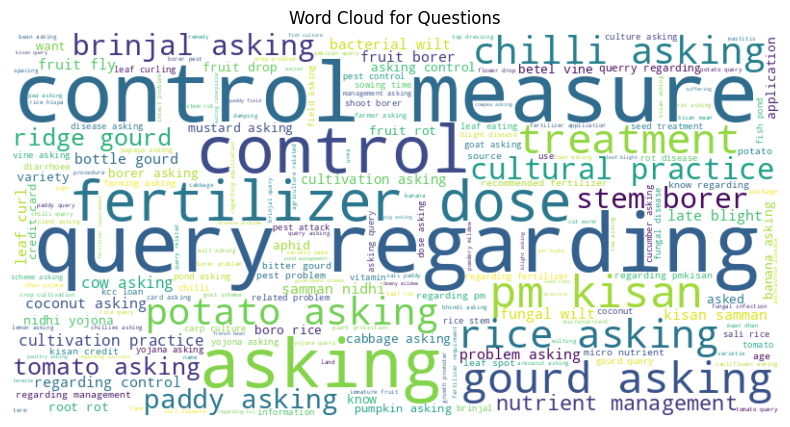

In [8]:

# Generate and plot word cloud
question_wc = WordCloud(width=800, height=400, background_color='white').generate(questions_text)

plt.figure(figsize=(10, 5))
plt.imshow(question_wc, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Questions")
plt.show()


**Comments**

* It is very clear that this dataset is an agricultural one. With most words related to agriculture.

**Question lenghts**

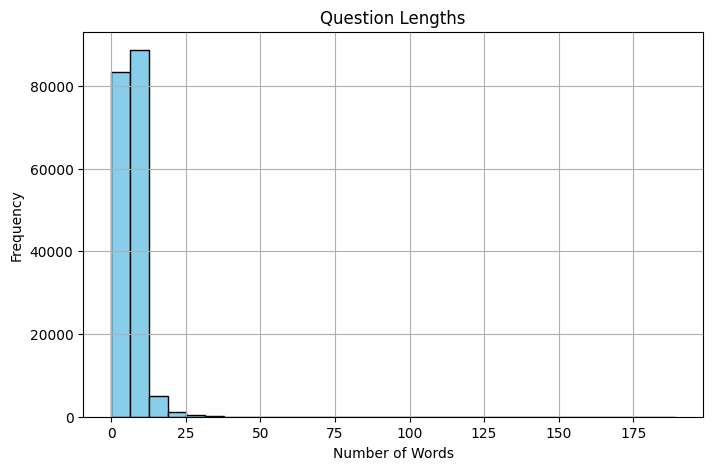

In [9]:
# Get question lengths by applying split to each individual question
question_lengths = data['questions'].dropna().apply(lambda x: len(str(x).split()))

# Plot question lengths
plt.figure(figsize=(8, 5))
plt.hist(question_lengths, bins=30, color='skyblue', edgecolor='black')
plt.title('Question Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


**Comments**

* From the histogram, it is clear that most questions are very short Thus i do not need to use agressive padding.
* Dynamic batching or atention masks will definately suffice.
* This also means i can comfortably set a max length wich is relatively small thus, 60 tokens for questions.

**Word Cloud for Answers**

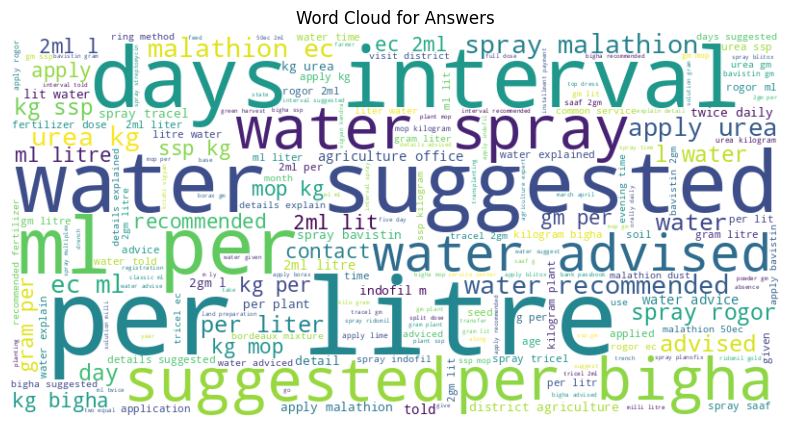

In [10]:
# Generating and ploting
answer_wc = WordCloud(width=800, height=400, background_color='white').generate(answers_text)

plt.figure(figsize=(10, 5))
plt.imshow(answer_wc, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Answers")
plt.show()



**Answer Length**

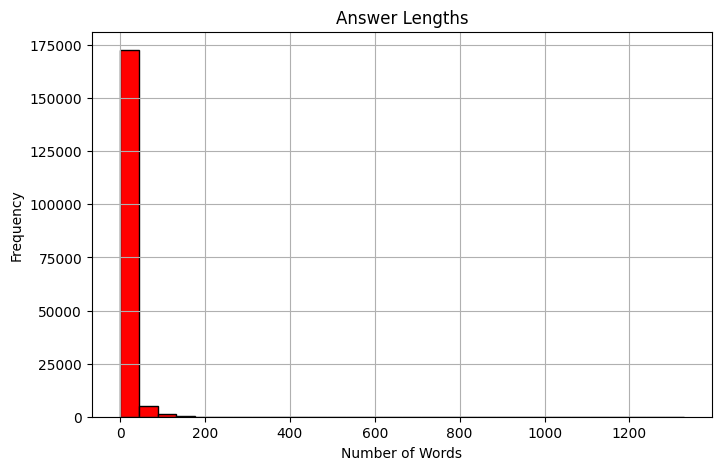

In [11]:
# Get question lengths by applying split to each individual question
question_lengths = data['answers'].dropna().apply(lambda x: len(str(x).split()))

# Plot question lengths
plt.figure(figsize=(8, 5))
plt.hist(question_lengths, bins=30, color='red', edgecolor='black')
plt.title('Answer Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


**Comment**

Most answers are also very short hence i can safely decide my padding between a range of 64 to 128.

**Words with Apostrophes and Contractions**

In [12]:


# Combining questions and answrs
strings = questions_text + answers_text

#make the text one big text

sum_strings = "".join(strings)

# regular expression for finding words containg apostrophes
pattern = re.compile(r"[\w]*'[\w]*")

#All matches of the pattern 
match = re.findall(pattern, sum_strings)

#removing duplicates and converting intoa set



In [13]:
print(set(match))

{"'actara", "jyoti'", "'saaf", "ball'", "'nahor", "'", "wife's", "cook'", "angue'", "27'", "'q", "'phytolin", "couldn't", "you've", "acre'", "'pride", "cow's", "'neem", "'bahadur", "super'", "2396510'", "send'", "2842513'", "carp'", "mission'", "'cifacure", "booster'", "leaf'", "'zineb", "ec'", "'no", "'toximar", "'plantomycin", "19'", "'borax", "'o2", "'agrimycin", "'aminose", "mother's", "shed'", "'dimacrone", "sbi's", "won't", "gm'", "'wincrop", "'cover", "marek's", "20'", "'feed", "'mahyco", "'tracel", "object'", "march'18", "house'", "'1000", "'fixotic", "'cptan", "'the", "jaymati'", "225384'", "'bipul", "mildew'", "d'mag", "'termeric", "'bio", "assam's", "don't", "'bavistin", "'padmanath", "kanaklata'", "'monocrotophos", "sty'", "docs'", "meen'", "'roban", "s'", "505'", "'sms", "builders'", "78'", "'thidane", "plant'", "50'", "centre's", "'rayada", "'bodeauex", "09954411012'", "'classic", "officer's", "'green", "syngenta'", "'exotic", "'november", "'03752", "t'o", "301'", "'40", 

# Preprocessing

**Handling contractions (word shortcuts) and Apostrophes**

English Contractions

In [14]:
contractions = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "cannot have",
    "cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "I'd": "I would",
    "I'd've": "I would have",
    "I'll": "I will",
    "I'm": "I am",
    "I've": "I have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you're": "you are",
    "you've": "you have"
}


In [15]:
# Precompile the contraction regex for known keys
pattern = re.compile(r'\b(' + '|'.join(re.escape(k) for k in contractions) + r')\b', flags=re.IGNORECASE)

def expand_contractions(text):
    def replace(match):
        contraction = match.group(0).lower()
        return contractions.get(contraction, contraction)
    
    return pattern.sub(replace, text)


**Application to the data**

In [16]:
# Expand contractions with NaN handling
data['questions'] = data['questions'].fillna('').astype(str).apply(expand_contractions)
data['answers'] = data['answers'].fillna('').astype(str).apply(expand_contractions)

Checking contactions.

In [17]:
# Check for remaining contractions
contractions_list = ["n't", "'re", "'s", "'d", "'ll", "'t", "'ve", "'m"]

for c in contractions_list:
    # Use na=False to handle NaN values
    q_count = data['questions'].str.contains(c, na=False).sum()
    a_count = data['answers'].str.contains(c, na=False).sum()
    print(f"Remaining '{c}': Questions: {q_count}, Answers: {a_count}")

Remaining 'n't': Questions: 0, Answers: 1
Remaining ''re': Questions: 0, Answers: 21
Remaining ''s': Questions: 41, Answers: 224
Remaining ''d': Questions: 4, Answers: 114
Remaining ''ll': Questions: 0, Answers: 0
Remaining ''t': Questions: 1, Answers: 182
Remaining ''ve': Questions: 0, Answers: 1
Remaining ''m': Questions: 2, Answers: 656


**Comment**


All contractions have been removed and only Possessives and native Luganda words are remaining. This is mainly because Possessives contain critical cotextual meaning and removing the 's will definatly lead to ambiguity and confusion within the phrases.And since I am using modern Bert there is no need to strip the 's.

**Removing special charecters, putting Lowe case and Normalising whitespace**

In [18]:
def preprocess(text):
    
    # Lowercasing
    text = text.lower()
    
    # Removing special characters
    text = re.sub(r'[^a-z0-9\s]', '', text)

    # Normalising whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [19]:
# Replace 'df' with 'data' (assuming your DataFrame is named 'data')
data['questions'] = data['questions'].apply(preprocess)
data['answers'] = data['answers'].apply(preprocess)

**Check for any special characters**

In [20]:
# Corrected code with proper DataFrame name and error handling
special_chars_q = data['questions'].apply(
    lambda x: bool(re.search(r'[^a-z0-9\s]', str(x))) if pd.notnull(x) else False
).sum()

special_chars_a = data['answers'].apply(
    lambda x: bool(re.search(r'[^a-z0-9\s]', str(x))) if pd.notnull(x) else False
).sum()

print(f"Questions with special characters: {special_chars_q}")
print(f"Answers with special characters: {special_chars_a}")

Questions with special characters: 0
Answers with special characters: 0


**Visualisations**

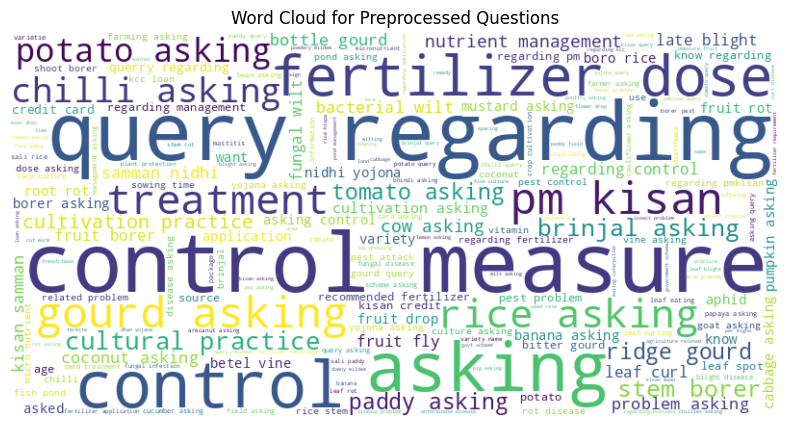

In [21]:
question_text = " ".join(data['questions'])
question_wc = WordCloud(width=800, height=400, background_color='white').generate(question_text)
plt.figure(figsize=(10, 5))
plt.imshow(question_wc, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Preprocessed Questions")
plt.show()

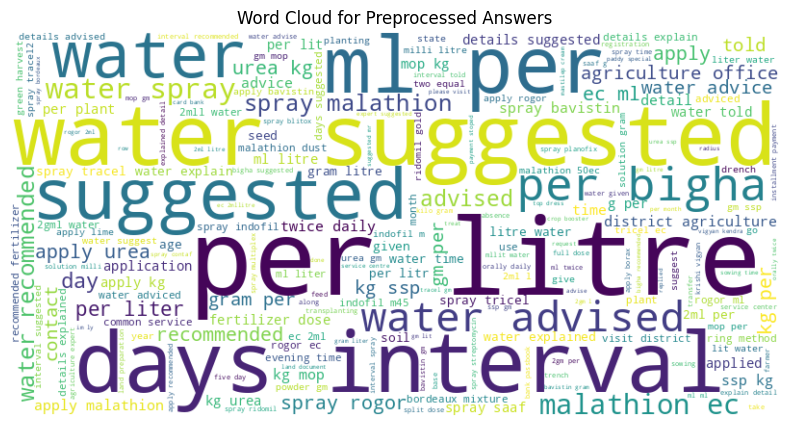

In [22]:
answer_text = " ".join(data['answers'])
answer_wc = WordCloud(width=800, height=400, background_color='white').generate(answer_text)
plt.figure(figsize=(10, 5))
plt.imshow(answer_wc, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Preprocessed Answers")
plt.show()

# Model Preparation

**Initializing Bert tokenizer**

# Training setup

Setting up evaluation metrics

In [23]:
# Load BLEU metric
bleu = evaluate.load("bleu")


Environment

In [24]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Splitting data

In [25]:
data['input_text'] = data['questions'].apply(preprocess).apply(lambda x: "question: " + x)
data['target_text'] = data['answers'].apply(preprocess)tr

In [26]:

# Train/val split
train_df = data.sample(frac=0.8, random_state=42)
val_df = data.drop(train_df.index)

# Convert to Hugging Face Datasets
train_ds = Dataset.from_pandas(train_df[['input_text', 'target_text']])
val_ds = Dataset.from_pandas(val_df[['input_text', 'target_text']])

# Bert2Bert Model Experiment 1

**Loading small bert and tokeniser**

In [27]:
# Load small BERT
model_checkpoint = "prajjwal1/bert-mini"
tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
model = EncoderDecoderModel.from_encoder_decoder_pretrained(model_checkpoint, model_checkpoint)

# Configure model
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.eos_token_id = tokenizer.sep_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.max_length = 128
model.config.no_repeat_ngram_size = 2
model.to(device)


Some weights of BertLMHeadModel were not initialized from the model checkpoint at prajjwal1/bert-mini and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.value.bias', 'bert.encoder.layer.0.crossattention.self.value.weight', 'bert.encoder.layer.1.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.1.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.1.crossattention.output.dense.bias', 'bert.encoder.layer.1.crossattention.output.dense.weight', 'bert.encoder.layer.1.crossattention.self.key.bias', 'bert

EncoderDecoderModel(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 256, padding_idx=0)
      (position_embeddings): Embedding(512, 256)
      (token_type_embeddings): Embedding(2, 256)
      (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-3): 4 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=256, out_features=256, bias=True)
              (LayerNorm): LayerNorm((256,), eps=1e-12, elem

**Tokenisation**

In [28]:
# Tokenization
max_input_len = 64
max_target_len = 128

def tokenize(batch):
    inputs = tokenizer(batch["input_text"], max_length=max_input_len, truncation=True, padding="max_length")
    outputs = tokenizer(batch["target_text"], max_length=max_target_len, truncation=True, padding="max_length")

    batch["input_ids"] = inputs.input_ids
    batch["attention_mask"] = inputs.attention_mask
    batch["labels"] = [
        [(label if label != tokenizer.pad_token_id else -100) for label in labels]
        for labels in outputs.input_ids
    ]
    return batch

train_ds = train_ds.map(tokenize, batched=True)
val_ds = val_ds.map(tokenize, batched=True)

# Set format
train_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Data collator
collator = DataCollatorForSeq2Seq(tokenizer, model=model, padding=True)

Map:   0%|          | 0/143151 [00:00<?, ? examples/s]

Map:   0%|          | 0/35788 [00:00<?, ? examples/s]

**Evaluation Function**

# Training

**Training Arguments**

In [30]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./small-bert2bert-agri",
    eval_strategy="no",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    save_total_limit=2,
    logging_dir="./logs",
    report_to="none",
    predict_with_generate=True,
    eval_accumulation_steps=4,
    generation_max_length=64,
)

**Trainer**

In [31]:

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
)



**Clear CUDA memory before training**

In [32]:
# Clear CUDA memory before training
torch.cuda.empty_cache()


In [33]:
# Train model
trainer.train()


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Step,Training Loss
500,4.526400
1000,3.357200
1500,3.040500
2000,2.844800
2500,2.631200
3000,2.509700
3500,2.474400
4000,2.350400
4500,2.316600
5000,2.247900


TrainOutput(global_step=89470, training_loss=1.5246856986203912, metrics={'train_runtime': 5248.7976, 'train_samples_per_second': 272.731, 'train_steps_per_second': 17.046, 'total_flos': 4142780961569280.0, 'train_loss': 1.5246856986203912, 'epoch': 10.0})

In [36]:
# Save model
model.save_pretrained("./small_bert2bert_chatbot")
tokenizer.save_pretrained("./small_bert2bert_chatbot")

('./small_bert2bert_chatbot/tokenizer_config.json',
 './small_bert2bert_chatbot/special_tokens_map.json',
 './small_bert2bert_chatbot/vocab.txt',
 './small_bert2bert_chatbot/added_tokens.json')

In [38]:
def generate_response(question):
    input_text = f"question: {question}"
    inputs = tokenizer(input_text, return_tensors="pt", padding="max_length", truncation=True, max_length=64)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    output = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_length=128,
        num_beams=4,
        early_stopping=True,
        decoder_start_token_id=model.config.decoder_start_token_id
    )
    return tokenizer.decode(output[0], skip_special_tokens=True)


# Test example
test_q = "how to grow tomatoes"
print(f"\nQ: {test_q}")
print(f"A: {generate_response(test_q)}")



Q: how to grow tomatoes
A: explained in details in package of practicesal adviced for better information givenalsal practicefertilizer dose from the time of sowingpprilizer crop booster of all crops in the month of januaryfebruaryuaryprilspvitamin forteapril and septoctvistin 2 ml per litre of wateremberchlorophosphal m 45 gram per bigha of landcin 1 kg per 25 kg of seedsrows along with the seedlings levelocycinthumum for


# T5 Model

**Tokenisation for T5**

In [40]:
from transformers import T5Tokenizer, T5ForConditionalGeneration, Seq2SeqTrainer, Seq2SeqTrainingArguments

# Load T5 model and tokenizer
t5_model_name = "t5-small"
t5_tokenizer = T5Tokenizer.from_pretrained(t5_model_name)
t5_model = T5ForConditionalGeneration.from_pretrained(t5_model_name)
t5_model.to(device)

# Tokenization function for T5 (reuse your preprocessed dataset)
def t5_tokenize(batch):
    inputs = t5_tokenizer(batch["input_text"], max_length=64, truncation=True, padding="max_length")
    outputs = t5_tokenizer(batch["target_text"], max_length=128, truncation=True, padding="max_length")

    batch["input_ids"] = inputs.input_ids
    batch["attention_mask"] = inputs.attention_mask
    batch["labels"] = [
        [(label if label != t5_tokenizer.pad_token_id else -100) for label in labels]
        for labels in outputs.input_ids
    ]
    return batch

# Tokenize datasets
t5_train_ds = train_ds.map(t5_tokenize, batched=True)
t5_val_ds = val_ds.map(t5_tokenize, batched=True)
t5_train_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
t5_val_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Data collator for T5
from transformers import DataCollatorForSeq2Seq
t5_collator = DataCollatorForSeq2Seq(t5_tokenizer, model=t5_model, padding=True)



Map:   0%|          | 0/143151 [00:00<?, ? examples/s]

Map:   0%|          | 0/35788 [00:00<?, ? examples/s]

Metrics

In [41]:
# BLEU metric and compute function (reusing your existing one)
def compute_t5_metrics(eval_pred):
    import numpy as np
    predictions, labels = eval_pred
    labels = np.where(labels != -100, labels, t5_tokenizer.pad_token_id)
    decoded_preds = t5_tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = t5_tokenizer.batch_decode(labels, skip_special_tokens=True)
    return bleu.compute(predictions=[p.split() for p in decoded_preds],
                        references=[[l.split()] for l in decoded_labels])



In [42]:
# T5 training arguments
t5_training_args = Seq2SeqTrainingArguments(
    output_dir="./t5-agri-chatbot",
    eval_strategy="no",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    predict_with_generate=True,
    logging_dir="./logs_t5",
    report_to="none",
    save_total_limit=2,
    eval_accumulation_steps=4
)

# T5 Trainer
t5_trainer = Seq2SeqTrainer(
    model=t5_model,
    args=t5_training_args,
    train_dataset=t5_train_ds,
    eval_dataset=t5_val_ds,
    tokenizer=t5_tokenizer,
    data_collator=t5_collator,
    compute_metrics=compute_t5_metrics
)



In [43]:
# Train T5
t5_trainer.train()

# Save model
t5_model.save_pretrained("./t5-agri-chatbot")
t5_tokenizer.save_pretrained("./t5-agri-chatbot")


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss
500,4.215100
1000,3.403600
1500,3.156400
2000,3.000600
2500,2.869300
3000,2.748200
3500,2.702300
4000,2.608300
4500,2.552600
5000,2.521100


('./t5-agri-chatbot/tokenizer_config.json',
 './t5-agri-chatbot/special_tokens_map.json',
 './t5-agri-chatbot/spiece.model',
 './t5-agri-chatbot/added_tokens.json')

In [82]:
from tqdm import tqdm
import evaluate

bleu = evaluate.load("bleu")

def evaluate_model(model, tokenizer, val_ds, device, model_type="bert"):
    model.eval()
    preds = []
    labels = []
    inputs_list = []

    for example in tqdm(val_ds):
        input_text = example["input_text"]
        target_text = example["target_text"]

        # Tokenize the input
        inputs = tokenizer(
            input_text,
            return_tensors="pt",
            max_length=64,
            truncation=True,
            padding="max_length"
        ).to(device)

        # Generate the model's prediction
        if model_type == "bert":
            decoder_start_token_id = model.config.decoder_start_token_id
            output_ids = model.generate(
                input_ids=inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                max_length=128,
                num_beams=4,
                early_stopping=True,
                decoder_start_token_id=decoder_start_token_id
            )
        else:  # T5
            output_ids = model.generate(
                input_ids=inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                max_length=128,
                num_beams=4,
                early_stopping=True
            )

        pred_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

        preds.append(pred_text)
        labels.append(target_text)
        inputs_list.append(input_text)

    return inputs_list, preds, labels


In [83]:
# BERT2BERT Evaluation
inputs_bert, preds_bert, labels_bert = evaluate_model(model, tokenizer, val_ds, device, model_type="bert")

  3%|▎         | 1007/35788 [14:59<8:37:55,  1.12it/s]


KeyboardInterrupt: 

In [84]:

# T5 Evaluation
inputs_t5, preds_t5, labels_t5 = evaluate_model(t5_model, t5_tokenizer, val_ds, device, model_type="t5")


  0%|          | 21/35788 [00:05<2:31:29,  3.93it/s]


KeyboardInterrupt: 

# Experiments

In [2]:
bert_experiments = [
    {"learning_rate": 5e-5, "batch_size": 8, "num_train_epochs": 5, "weight_decay": 0.01},
    {"learning_rate": 3e-5, "batch_size": 16, "num_train_epochs": 6, "weight_decay": 0.0},
    {"learning_rate": 2e-5, "batch_size": 8, "num_train_epochs": 10, "weight_decay": 0.01},
    {"learning_rate": 1e-4, "batch_size": 4, "num_train_epochs": 4, "weight_decay": 0.05},
    {"learning_rate": 3e-4, "batch_size": 8, "num_train_epochs": 3, "weight_decay": 0.1},
]

t5_experiments = [
    {"learning_rate": 5e-5, "batch_size": 8, "num_train_epochs": 5, "weight_decay": 0.01},
    {"learning_rate": 3e-5, "batch_size": 16, "num_train_epochs": 6, "weight_decay": 0.0},
    {"learning_rate": 2e-5, "batch_size": 8, "num_train_epochs": 10, "weight_decay": 0.01},
    {"learning_rate": 1e-4, "batch_size": 4, "num_train_epochs": 4, "weight_decay": 0.05},
    {"learning_rate": 3e-4, "batch_size": 8, "num_train_epochs": 3, "weight_decay": 0.1},
]


# Bert Experiments

In [3]:
def run_bert_experiment(exp_num, config):
    from transformers import Trainer, Seq2SeqTrainingArguments

    args = Seq2SeqTrainingArguments(
        output_dir=f"./bert_exp{exp_num}",
        per_device_train_batch_size=config["batch_size"],
        per_device_eval_batch_size=config["batch_size"],
        learning_rate=config["learning_rate"],
        weight_decay=config["weight_decay"],
        num_train_epochs=config["num_train_epochs"],
        eval_strategy="epoch",
        save_strategy="no",
        predict_with_generate=True,
        logging_dir=f"./logs/bert_exp{exp_num}",
        report_to="none",
    )

    trainer = Trainer(
        model=model,  # Your BERT2BERT model
        args=args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=tokenizer,
        data_collator=collator,
        compute_metrics=compute_metrics,
    )

    print(f"\n[Running BERT Experiment {exp_num}]")
    trainer.train()
    metrics = trainer.evaluate()
    return metrics["eval_bleu"], f"./bert_exp{exp_num}"


# T5 experiments


In [4]:
def run_t5_experiment(exp_num, config):
    from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

    args = Seq2SeqTrainingArguments(
        output_dir=f"./t5_exp{exp_num}",
        per_device_train_batch_size=config["batch_size"],
        per_device_eval_batch_size=config["batch_size"],
        learning_rate=config["learning_rate"],
        weight_decay=config["weight_decay"],
        num_train_epochs=config["num_train_epochs"],
        eval_strategy="epoch",
        save_strategy="no",
        predict_with_generate=True,
        logging_dir=f"./logs/t5_exp{exp_num}",
        report_to="none",
    )

    trainer = Seq2SeqTrainer(
        model=t5_model,
        args=args,
        train_dataset=t5_train_ds,
        eval_dataset=t5_val_ds,
        tokenizer=t5_tokenizer,
        data_collator=t5_collator,
        compute_metrics=compute_t5_metrics,
    )

    print(f"\n[Running T5 Experiment {exp_num}]")
    trainer.train()
    metrics = trainer.evaluate()
    return metrics["eval_bleu"], f"./t5_exp{exp_num}"


# Experiment evaluations

In [5]:
best_bleu = -1
best_model_path = None
best_model_type = ""

# Run BERT2BERT experiments
for i, config in enumerate(bert_experiments):
    bleu_score, path = run_bert_experiment(i + 1, config)
    print(f"BERT Exp {i+1} BLEU: {bleu_score:.4f}")
    if bleu_score > best_bleu:
        best_bleu = bleu_score
        best_model_path = path
        best_model_type = "BERT2BERT"

# Run T5 experiments
for i, config in enumerate(t5_experiments):
    bleu_score, path = run_t5_experiment(i + 1, config)
    print(f"T5 Exp {i+1} BLEU: {bleu_score:.4f}")
    if bleu_score > best_bleu:
        best_bleu = bleu_score
        best_model_path = path
        best_model_type = "T5"


2025-06-21 21:18:23.754414: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750540703.993404      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750540704.062558      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


NameError: name 'model' is not defined

# Evaluatin Table

In [1]:
import pandas as pd

results = []

# BERT2BERT Experiments
for i, config in enumerate(bert_experiments):
    bleu_score, path = run_bert_experiment(i + 1, config)
    results.append({
        "Exp No": i + 1,
        "Model": "BERT2BERT",
        "Learning Rate": config["learning_rate"],
        "Batch Size": config["batch_size"],
        "Epochs": config["num_train_epochs"],
        "Weight Decay": config["weight_decay"],
        "BLEU Score": bleu_score
    })

# T5 Experiments
for i, config in enumerate(t5_experiments):
    bleu_score, path = run_t5_experiment(i + 6, config)  # Start from Exp No 6
    results.append({
        "Exp No": i + 6,
        "Model": "T5",
        "Learning Rate": config["learning_rate"],
        "Batch Size": config["batch_size"],
        "Epochs": config["num_train_epochs"],
        "Weight Decay": config["weight_decay"],
        "BLEU Score": bleu_score
    })

# Create DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="BLEU Score", ascending=False).reset_index(drop=True)

# Display table
print(results_df)


NameError: name 'bert_experiments' is not defined